<a href="https://colab.research.google.com/github/cnydo/Image-colorization/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle


In [ ]:
!ls

kaggle.json  sample_data


Upload kaggle json tp drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! ls -l ~/.kaggle/kaggle.json

-rw------- 1 root root 62 Nov  2 21:48 /root/.kaggle/kaggle.json


Download from kaggle dataset

In [ ]:
! kaggle datasets download laurentmih/aisegmentcom-matting-human-datasets

100% 28.8G/28.8G [03:11<00:00, 132MB/s]
100% 28.8G/28.8G [03:11<00:00, 162MB/s]


In [ ]:
!unzip /content/aisegmentcom-matting-human-datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000298.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000304.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000315.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000323.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000324.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000327.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000330.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000339.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000344.png  
  inflating: matting_human_half/matting/1803271743/matting_00000000/1803271743-00000356.png  
  inflati

In [ ]:
!pip install basic_image_eda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-image scipy sklearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=7710d9962978a7f715a09b24c1e965b10cf7bce26f42790359194a22bb89e067
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from time import time
from PIL import Image
from basic_image_eda import BasicImageEDA
import cv2
import skimage
from skimage.color import rgb2lab, lab2rgb


import glob
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from itertools import islice

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  2 21:58:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
human_ds_path = r"/content/clip_img"
human_img_paths = glob.glob(human_ds_path + "/**/*.jpg", recursive=True)

In [ ]:
train_paths, val_test_paths = train_test_split(human_img_paths, test_size=0.2,random_state=42)
val_paths,test_paths = train_test_split(val_test_paths, test_size=0.5, random_state=42)
print("train images:", len(train_paths))
print("val images:", len(val_paths))
print("test images:", len(test_paths))

train images: 27540
val images: 3442
test images: 3443



found 34425 images.
Using 12 threads. (max:12)



100%|██████████| 34425/34425 [05:00<00:00, 114.66it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  34425

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  800
max height                               |  800
mean height                              |  800.0
median height                            |  800

min width                                |  600
max width                                |  600
mean width                               |  600.0
median width                             |  600

mean height/width ratio                  |  1.3333333333333333
median height/width ratio                |  1.3333333333333333
recommended input size(by mean)          |  [800 600] (h x w, multiples of 8)
recommended input size(by mean)          |  [800 608] (h x w, multiples of 16)
recommended input size(by mean)    

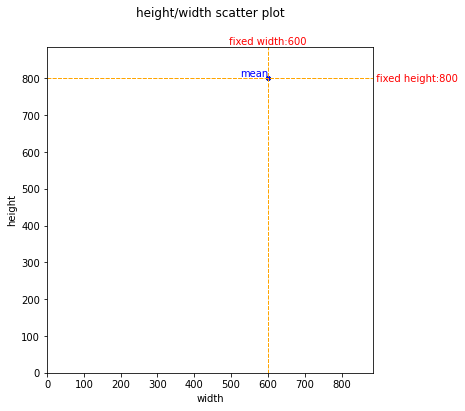

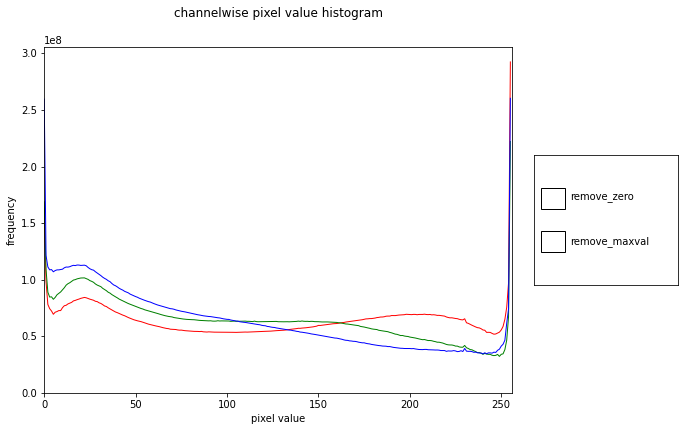

{'dtype': 'uint8',
 'channels': [3],
 'extensions': ['jpg'],
 'min_h': 800,
 'max_h': 800,
 'mean_h': 800.0,
 'median_h': 800,
 'min_w': 600,
 'max_w': 600,
 'mean_w': 600.0,
 'median_w': 600,
 'mean_hw_ratio': 1.3333333333333333,
 'median_hw_ratio': 1.3333333333333333,
 'rec_hw_size_8': array([800, 600]),
 'rec_hw_size_16': array([800, 608]),
 'rec_hw_size_32': array([800, 608]),
 'mean': array([0.493729  , 0.43179843, 0.3994736 ], dtype=float32),
 'std': array([0.30542526, 0.2891053 , 0.2929794 ], dtype=float32)}

In [ ]:
extensions = ['jpg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0
BasicImageEDA.explore(human_ds_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

In [ ]:
SIZE = 256
class ColorizationDataset:
    def __init__(self, paths, split = 'train') -> None:
        # set self.transforms based on split type 
        if split == 'train':
            self.transforms = transforms.Compose([
                # Resize
                transforms.Resize((SIZE,SIZE), transforms.InterpolationMode.BICUBIC), 
                # Flip
                transforms.RandomHorizontalFlip(),  
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE), transforms.InterpolationMode.BICUBIC)
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)  
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # convert to lab color space and convert to float32
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] # luminance channel (black and white) - [0~100] - this is what we will give to the network as input 
        ab = img_lab[[1, 2], ...] # color channels - [-128~127] - these are what we will predict with the network
        
        L = L / 50 - 1 # normalize L channel to [-1,1]
        ab = 2 * (ab + 128) / 255 - 1 # normalize ab channels to [-1,1]
        return {"L": L, "ab": ab}
    
    def __len__(self):
        "Returning the length of the dataset."
        return len(self.paths) 
    
def make_loader(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    ds = ColorizationDataset(**kwargs)
    loader = DataLoader(ds, batch_size=16, num_workers=4, pin_memory=False)
    return loader

In [ ]:
train_dloader = make_loader(paths = train_paths,split = 'train')
val_dloader = make_loader(paths = val_paths, split = 'val')


In [ ]:
data = next(iter(train_dloader))

In [ ]:
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dloader), len(val_dloader))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
1722 216


In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)
            

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = 255*ab / 2 - 128
    #ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
import time
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dloader)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=True) # function displaying the model's outputs

model = MainModel()
with tf.device('/device:GPU:0'):
    # Start with 10 epochs
    train_model(model, train_dloader, 1)



In [ ]:
test_dloader = make_loader(paths = train_paths, split = 'val')
def test_model(model, display_every = 200):b
    data = next(iter(test_dloader))
    i = 0
    model.setup_input(data)
    

